# Trail Stats Data Cleaning

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='white')

## Functions

In [2]:
def distance_cleaner(dataf, dist_col):
    df.loc[df[col].isna(), col] = 'NaN'
    
    # capturing the original distance measure in a new column
    dataf.loc[dataf[dist_col].str.contains('ft'), '{}_measure'.format(dist_col)] = 'feet'
    dataf.loc[dataf[dist_col].str.contains('miles'), '{}_measure'.format(dist_col)] = 'miles'
    
    # cleaning the text to remove non-numeric characters
    dataf[dist_col] = dataf[dist_col].str.replace('miles', '').str.strip()
    dataf[dist_col] = dataf[dist_col].str.replace('ft', '').str.strip()
    dataf[dist_col] = dataf[dist_col].str.replace(',', '')
    
    # replacing nulls and converting to floats
    dataf.loc[dataf[dist_col] == 'NaN', dist_col] = np.nan
    dataf.loc[dataf[dist_col] == 'BUMMER', dist_col] = np.nan
    dataf[dist_col] = dataf[dist_col].astype('float')
    
    #converting all non-feet units to feet
    dataf.loc[df['{}_measure'.format(dist_col)] == 'miles', dist_col] = dataf.loc[df['{}_measure'.format(dist_col)] == 'miles', dist_col] * 5280
    
def unique_categories(df, col):
    unique_cat = []
    for i in df[col]:
        hold = i.split(',')
        for cat in hold:
            cat = cat.strip()
            if cat not in unique_cat:
                unique_cat.append(cat)
    return unique_cat

def bummer_to_nan(dataf, col):
    #all of the operations happen inplace so reassignment with the function isn't necessary
    dataf[col] = dataf[col].str.replace(' Reviews & Comments', '').str.replace(',', '')
    dataf[col] = dataf[col].str.replace(' Review & Comments', '').str.replace(',', '')
    dataf.loc[dataf[col] == 'BUMMER', col] = np.NaN
    dataf[col] = dataf[col].astype('float')
    
def string_list_dummies(unique_items_list, dataf, orig_col):
    for item in unique_items_list:
        if item != 'BUMMER' and item != '':
            col_title = item.lower().replace(' ', '_')
            dataf.loc[:, col_title] = 0
            dataf.loc[df[orig_col].str.contains(item), col_title] = 1

## Data Loading & Column Name Cleaning

In [3]:
df = pd.read_json('usa_trails_details_102019.json')

In [4]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

cat_col = ['bike_type', 'difficulty_rating', 'dogs_allowed', 'riding_area',
           'ttfs_on_trail', 'trail_type', 'description', 'location', 'trail_name',
           'trail_id'
          ]
       
numeric_col = [col for col in df.columns if col not in cat_col]

non_distance_numeric_col = ['global_ranking', 'grade', 'grade_max',
                            'grade_min', 'comment_count', 'total_rides',
                            'average_time'
                           ]

distance_col = [col for col in numeric_col if col not in non_distance_numeric_col]

In [5]:
#stripping leading and trailing whitespace from all categorical columns
for col in cat_col:
    df[col] = df[col].str.strip()

## Null Identification and Numerical Cleaning

In [6]:
original_columns = df.columns
for col in df.columns:
    nulls = len(df.loc[df[col].isna()])
    bummers = len(df.loc[df[col] == 'BUMMER'])
    col_null = nulls + bummers
    print('{}:\t\t{}'.format(col, col_null))

trail_id:		12
trail_name:		1
climb:		5258
descent:		4004
distance:		331
description:		1
grade_min:		703
grade:		3761
distance_climb:		3988
grade_max:		669
altitude_change:		1436
distance_down:		3004
altitude_start:		334
altitude_min:		354
altitude_end:		335
distance_flat:		8906
altitude_max:		16681
average_time:		16527
total_rides:		651
comment_count:		52311
location:		101
riding_area:		101
difficulty_rating:		1
trail_type:		1
bike_type:		25366
dogs_allowed:		2534
ttfs_on_trail:		51667
global_ranking:		16396


In [7]:
for col in distance_col:
    distance_cleaner(df, col)

In [8]:
altitudes = ['altitude_start', 'altitude_end', 'altitude_max', 'altitude_min', 'altitude_change']
#site uses -16213.0 for all altitude categories in some cases
df.loc[df['altitude_start'] == -16213.0, altitudes] = np.NaN

In [9]:
#filling in max altitudes using min altitude and altitude change
df.loc[:, 'imputed_altitude_max'] = 0
df.loc[df['altitude_max'].isna(), 'imputed_altitude_max'] = 1

df.loc[:, 'imputed_altitude_change'] = 0
df.loc[df['altitude_change'].isna(), 'imputed_caltitude_change'] = 1

mask_descend = (
    (df['altitude_max'].isna()) & 
    (df['altitude_change'].notna()) &
    (df['altitude_start'] > df['altitude_end'])
)
df.loc[mask_descend, 'altitude_max'] = (df.loc[mask_descend, 'altitude_min'] + 
                                        abs(df.loc[mask_descend, 'altitude_change']))

mask_climb = (
    (df['altitude_max'].isna()) & 
    (df['altitude_change'].notna()) &
    (df['altitude_start'] < df['altitude_end'])
)
df.loc[mask_climb, 'altitude_max'] = (df.loc[mask_climb, 'altitude_min'] + 
                                      (df.loc[mask_climb, 'altitude_change']))

mask = (
    (df['altitude_max'].isna()) & 
    (df['altitude_start'] == df['altitude_end']) &
    (df['altitude_start'] > df['altitude_min']) |
    (df['altitude_start'] == df['altitude_min'])
)
df.loc[mask, 'altitude_max'] = df.loc[mask, 'altitude_start']

mask = (
    (df['altitude_max'].isna()) & 
    (df['altitude_start'] < df['altitude_end'])
)
df.loc[mask, 'altitude_max'] = df.loc[mask, 'altitude_end']

mask = (
    (df['altitude_max'].isna()) & 
    (df['altitude_start'] > df['altitude_end'])
)
df.loc[mask, 'altitude_max'] = df.loc[mask, 'altitude_start']

In [10]:
#cleaning a few nulls where no altitude changes for the trail
mask = (
    (df['altitude_start'] == df['altitude_end']) & 
    (df['altitude_end'] == df['altitude_max']) &
    (df['altitude_max'] == df['altitude_min']) &
    (df['altitude_change'].isna())
)
df.loc[mask, 'altitude_change'] = 0.0
df.loc[df['altitude_min'] < -150, 'altitude_min'] = df.loc[df['altitude_min'] < -150, 'altitude_end']

In [11]:
print('Starting Altitude Change nulls:', len(df.loc[df.altitude_change.isna()]))
mask = (
    (df['altitude_change'].isna()) 
)
df.loc[mask, 'altitude_change'] = df.loc[mask, 'altitude_end'] - df.loc[mask, 'altitude_start']
print('Ending Altitude Change nulls:', len(df.loc[df.altitude_change.isna()]))

Starting Altitude Change nulls: 1282
Ending Altitude Change nulls: 355


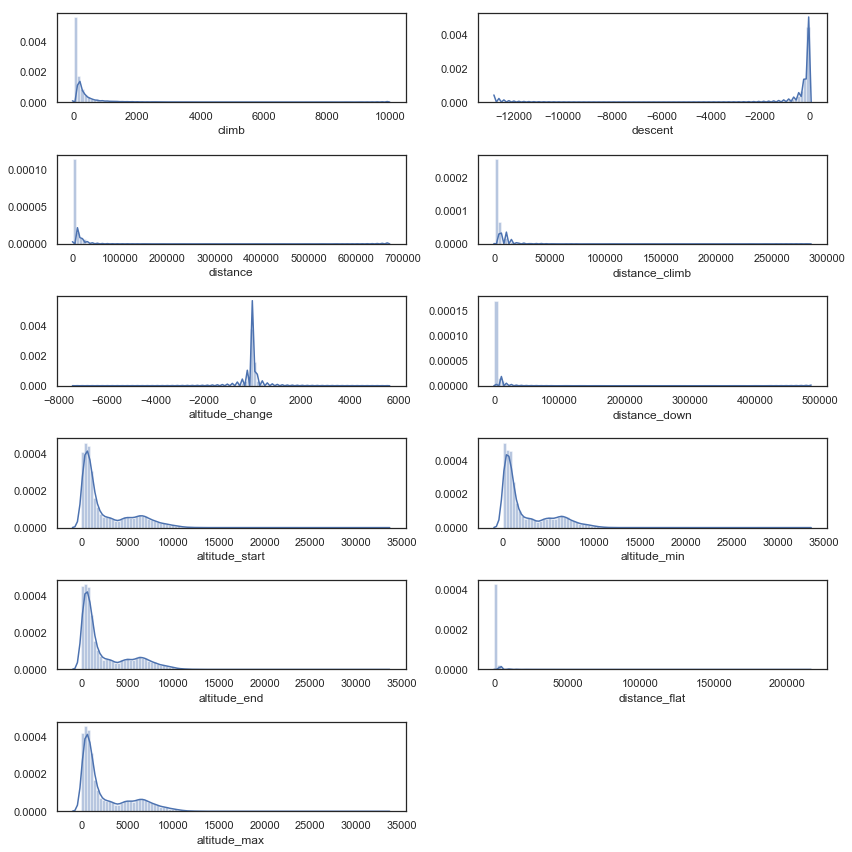

In [14]:
plt.figure(figsize=(12,12))
n = 1
for col in distance_col:
    plt.subplot(6, 2, n)
    sns.distplot(df[col], bins=100)
    n += 1
plt.tight_layout()    
plt.show()

There are a couple of interesting outliers here. The distance column has quite a few trails over 100,000 feet long (~19 miles). After reviewing some of the trail descriptions there are a few that are multi-use snowmobile or jeep roads that people ride. Thankfully this does not look like the result of errors with the feet conversion.

The other issue to address are the trails with altitudes of 30,000+ feet, which would put them higher than Mt. Everest.... suspicious to say the least.

In [15]:
df.loc[df.altitude_max > 14000, ['trail_name', 'location', 'distance', 'total_rides', 'average_time', 'altitude_change', 'altitude_max', 'altitude_min', 'altitude_start', 'altitude_end']]

,trail_name,location,distance,total_rides,average_time,altitude_change,altitude_max,altitude_min,altitude_start,altitude_end
2063,Badger Pass Climb,"Las Vegas, Nevada",1857.0,"1,332",00:04:02,-325.0,15200.0,14875.0,15200.0,14875.0
4372,Bomb Voyage,"Las Vegas, Nevada",10560.0,171,00:25:22,-3294.0,16070.0,12690.0,15984.0,12690.0
15333,Hardy’s Hill,"Poultney, Vermont",10560.0,15,00:19:51,0.0,32708.0,32708.0,32708.0,32708.0
16369,Homestake Trail,"Deadwood-Lead, South Dakota",15840.0,11,00:27:48,2002.0,17287.0,14919.0,14929.0,16932.0
19727,Little Jimmy Switchbacks,"Las Vegas, Nevada",1372.0,284,00:03:43,131.0,15994.0,15994.0,15994.0,16125.0
19728,Little Jimmy,"Las Vegas, Nevada",4863.0,273,00:11:59,764.0,16060.0,15262.0,15295.0,16060.0
22548,Mormon Mountain,"Sedona, Arizona",15840.0,4,00:39:38,-4252.0,27910.0,23488.0,27740.0,23488.0
29895,Rocky Ridge,"Poultney, Vermont",5280.0,37,00:14:16,0.0,19076.0,19076.0,19076.0,19076.0
30356,Rusty Bucket,"Poultney, Vermont",5280.0,59,00:10:13,0.0,24240.0,24240.0,24240.0,24240.0
35389,Three Amigos,"Las Vegas, Nevada",4820.0,16,00:18:53,-325.0,15564.0,15135.0,15545.0,15220.0


## Average Time, Difficulty Ratings, & Other Numeric Columns

In [16]:
#global ranking replace Bummers with np.NaN and remove commas
#comment count replace Bummers with np.NaN and Review & Comments 
#total_rides replace Bummers with np.NaN

other = ['global_ranking', 'comment_count', 'total_rides']

for column in other:
    bummer_to_nan(df, column)

#binarizing comment count due to number of nulls 
df.loc[:, 'has_comments'] = 0
df.loc[df.comment_count > 0, 'has_comments'] = 1

#if no rides have been reported then the total is 0
df.loc[df.total_rides.isna(), 'total_rides'] = 0

df.loc[:, 'globally_ranked'] = 1
df.loc[df.global_ranking.isna(), 'globally_ranked'] = 0

In [17]:
#converting average ride time to float minutes
times = df['average_time'].str.split(':')
df['avg_hours'] = [time[0] if time != 'BUMMER' else np.NaN for time in times]
df['avg_minutes'] = [time[1] if len(time) > 1 else np.NaN for time in times]
df['avg_seconds'] = [time[2] if len(time) > 1 else np.NaN for time in times]
df.loc[df['avg_hours'] == 'BUMMER', 'avg_hours'] = np.NaN

df['avg_ride_minutes'] = ((df['avg_hours'].astype('float') * 60) + 
                          (df['avg_minutes'].astype('float')) + 
                          (df['avg_seconds'].astype('float') / 60))

In [18]:
#if there aren't any rides to average then the ride time is 0
mask = (
    (df['avg_ride_minutes'].isna()) & 
    (df['total_rides'] == 0.0)
)
df.loc[mask, 'avg_ride_minutes'] = 0.0

In [19]:
df.avg_ride_minutes.isna().value_counts()

False    58166
True      1311
Name: avg_ride_minutes, dtype: int64

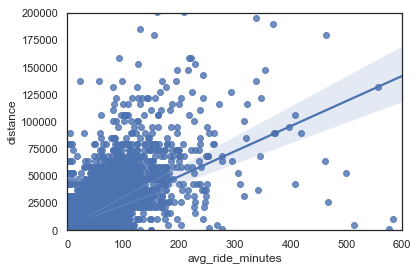

In [20]:
test = df.loc[(df.avg_ride_minutes>0) & (df.distance>0), ['avg_ride_minutes', 'distance']]
sns.regplot(x=test['avg_ride_minutes'], y=test['distance'], fit_reg=True)
plt.xlim(0,600)
plt.ylim(0,200000)
plt.show()

The spread in ride time compared to distance is a too wide to use that relationship to impute average ride time for the missing data points. I could make a new column called 'estimated_ride_time' that uses their relationship to predict how long it should take. That could be done by combining all of the distance/altitude/difficulty data into a linear regression model to predict the average minutes for the ride.

In [21]:
#if there is only one type of distance than the other two are zero
df.loc[df['distance'] == df['distance_climb'], ['distance_down', 'distance_flat']] = 0.0
df.loc[df['distance'] == df['distance_down'], ['distance_climb', 'distance_flat']] = 0.0
df.loc[df['distance'] == df['distance_flat'], ['distance_down', 'distance_climb']] = 0.0

#next block takes care of cases where only one of the distances is missing 
mask = (
    (df['distance_climb'].isna()) &
    ((df['distance_down'] + df['distance_flat']) != df['distance']) &
    ((df['distance_down'] + df['distance_flat']) < df['distance'])
)
df.loc[mask, 'distance_climb'] = df.loc[mask, 'distance'] - (df.loc[mask, 'distance_down'] + df.loc[mask, 'distance_flat'])

mask = (
    (df['distance_flat'].isna()) &
    ((df['distance_down'] + df['distance_climb']) != df['distance']) &
    ((df['distance_down'] + df['distance_climb']) < df['distance'])
)
df.loc[mask, 'distance_flat'] = df.loc[mask, 'distance'] - (df.loc[mask, 'distance_down'] + df.loc[mask, 'distance_climb'])

mask = (
    (df['distance_down'].isna()) &
    ((df['distance_climb'] + df['distance_flat']) != df['distance']) &
    ((df['distance_climb'] + df['distance_flat']) < df['distance'])
)
df.loc[mask, 'distance_down'] = df.loc[mask, 'distance'] - (df.loc[mask, 'distance_climb'] + df.loc[mask, 'distance_flat'])

#after all other cases are considered the rest of the nulls with no starting dist should be 0
for col in ['distance_down', 'distance_climb', 'distance_flat']:
    mask = (
        (df[col].isna()) &
        (df['distance'].notna())
    )
    df.loc[mask, col] = 0.0

In [22]:
for col in ['distance_down', 'distance_climb', 'distance_flat']:
    print(len(df.loc[df[col].isna()]))

331
331
331


In [23]:
mask = (
    (df['climb'].isna()) &
    (df['distance_climb'] == 0.0)
)
df.loc[mask, 'climb'] = 0.0

mask = (
    (df['descent'].isna()) &
    (df['distance_down'] == 0.0)
)
df.loc[mask, 'descent'] = 0.0

In [24]:
for col in ['descent', 'climb']:
    print(len(df.loc[df[col].isna()]))

1749
2087


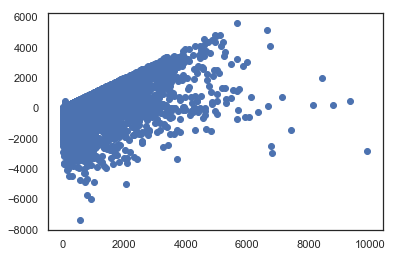

In [25]:
#plt.scatter(x=df['climb'], y=df['distance_climb'])
plt.scatter(x=df['climb'], y=df['altitude_change'])
plt.show()

In [26]:
df.loc[df.climb.isna(), ['distance_climb', 'altitude_change']].describe()

,distance_climb,altitude_change
count,1756.000000,1756.000000
mean,277.312642,-72.375285
std,1600.272924,129.881168
min,1.000000,-2034.000000
25%,29.000000,-87.000000
50%,58.000000,-23.000000
75%,120.000000,-4.000000
max,36596.000000,57.000000


In [27]:
df.loc[df.climb.isna(), ['climb', 'descent', 'distance_climb', 'distance_down', 'altitude_max', 'altitude_min', 'altitude_change']]

,climb,descent,distance_climb,distance_down,altitude_max,altitude_min,altitude_change
33,NaN,-22.0,82.0,518.0,7979.0,7955.0,-24.0
49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,-29.0,33.0,404.0,8000.0,7969.0,-31.0
71,NaN,-24.0,4.0,249.0,8005.0,7980.0,-25.0
73,NaN,-38.0,33.0,456.0,8022.0,7983.0,-39.0
...,...,...,...,...,...,...,...
59278,NaN,-237.0,29.0,2802.0,8898.0,8659.0,-239.0
59283,NaN,-18.0,15.0,287.0,4954.0,4935.0,-19.0
59293,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59473,NaN,-603.0,107.0,4150.0,1603.0,1000.0,-603.0


In [28]:
ratings = df['difficulty_rating'].str.split('/')
df['difficulty_value'] = [rating[0].strip() for rating in ratings]
df['difficulty_symbol'] = [rating[1].strip() if len(rating) > 1 else 'NaN' for rating in ratings]

#handling unique cases so that 
df.loc[df['difficulty_value'].str.contains('Access'), 'difficulty_value'] = 'Easy'
df.loc[df['difficulty_value'].str.contains('pros'), 'difficulty_value'] = 'Extremely Difficult'
df.loc[df['difficulty_value'].str.contains('Severe'), 'difficulty_value'] = 'Extremely Difficult'
df.loc[df['difficulty_value'].str.contains('Advanced'), 'difficulty_value'] = 'Very Difficult'
df.loc[df['difficulty_value'] == 'BUMMER', 'difficulty_value'] = 'NaN'
df['difficulty_value'].unique()

array(['Very Difficult', 'Intermediate', 'Easy', 'Extremely Difficult',
       'NaN', 'Easiest'], dtype=object)

In [29]:
#cleaning the symbols to match the value for difficulty, this is probably unnecessary since
#the difficulty value conveys the same information
difficulty = {'Easiest':'White Circle', 
              'Easy':'Green Circe', 
              'Intermediate':'Blue Square',
              'Very Difficult':'Black Diamond',
              'Extremely Difficult':'Dbl Black Diamond'
             }
for value in difficulty:
    df.loc[df['difficulty_value'] == value, 'difficulty_symbol'] = difficulty[value]
    
df['difficulty_symbol'].unique()

array(['Black Diamond', 'Blue Square', 'Green Circe', 'Dbl Black Diamond',
       'NaN', 'White Circle'], dtype=object)

## Location: City & State

In [30]:
df.loc[df['location'].isna(), 'city'] = 'NaN'
df.loc[df['location'].isna(), 'state'] = 'NaN'

In [31]:
#nulls are stored as np.Nan which limits the ability to manipulate the strings
#changing to 'NaN' so that city and state data can be separated
df.loc[df['location'].isna(), 'location'] = 'NaN'

location = df['location'].str.split(',')
df['city'] = ['NaN' if len(loc) == 1 else loc[0].strip() for loc in location]
df['state'] = [loc[1].strip() if len(loc) > 1 else loc[0].strip() for loc in location]

In [32]:
riding_area = df.loc[df.city == 'NaN', 'riding_area'].unique()
for ride in riding_area:
    city = df.loc[(df.riding_area == ride) & (df.city != 'NaN'), 'city']
    try:
        df.loc[(df.riding_area == ride) & (df.city == 'NaN'), 'city'] = city.values[0]
    except IndexError:
        df.loc[(df.riding_area == ride) & (df.city == 'NaN'), 'city'] = 'NaN'

In [33]:
#fixing some cities that can be inferred from riding area
riding_area_cities = {
    'San Francisco Bay Area':'San Francisco',
    'Washington DC':'Washington DC',
    'Santa Fe Area':'Santa Fe',
    'South Puget Sound':'Dupont',
    'San Luis Obispo County':'San Luis Obispo',
    'Mark Twain National Forest - Houston Rolla District':'Houston',
}

for ride in riding_area_cities:
    df.loc[df.riding_area == ride, 'city'] = riding_area_cities[ride]

In [34]:
len(df.loc[df.city == 'NaN'])

400

## Categorical String Dummy Conversion

In [35]:
ttfs = unique_categories(df, 'ttfs_on_trail')
bikes = unique_categories(df, 'bike_type')

In [36]:
string_list_dummies(ttfs, df, 'ttfs_on_trail')
string_list_dummies(bikes, df, 'bike_type')

## Descriptions, Gradients, & Other Columns

In [37]:
df.loc[df['dogs_allowed'] == 'BUMMER', 'dogs_allowed'] = 'No'

In [38]:
#there is a canned response for trails without a description, replacing that with 'NaN'
df.loc[df.description.str.contains('No description for'), 'description'] = 'No Description'
df.loc[df.description == 'BUMMER', 'description'] = 'No Description'

In [39]:
grades = ['grade', 'grade_max', 'grade_min']
for grade in grades:
    df[grade] = df[grade].str.replace('%', '').astype('float')

In [40]:
print(len(df.loc[df.grade.isna()]))
mask = (
    (df.grade.isna()) &
    (df.altitude_change.notna()) &
    (df.distance.notna())
)
df.loc[mask, 'grade'] = (df.loc[mask, 'altitude_change'] / df.loc[mask, 'distance']) * 100
print(len(df.loc[df.grade.isna()]))

3761
355


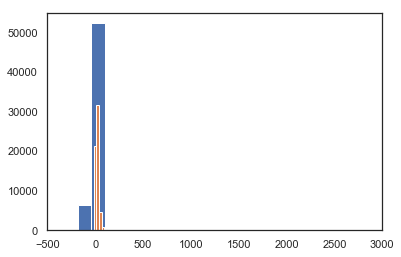

In [41]:
plt.hist(df['grade_max'], bins=100)
plt.hist(df['grade_min'], bins=100)
plt.xlim(-500, 3000)
plt.show()

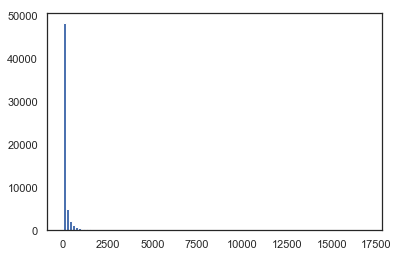

In [42]:
# checking to make sure total_rides was converted correctly
plt.hist(df['total_rides'], bins=100)
plt.show()

In [43]:
for col in original_columns:
    nulls = len(df.loc[df[col].isna()])
    #bummers = len(df.loc[df[col] == 'BUMMER'])
    #col_null = nulls + bummers
    print('{}:\t\t{}'.format(col, nulls))

trail_id:		12
trail_name:		0
climb:		2087
descent:		1749
distance:		331
description:		0
grade_min:		703
grade:		355
distance_climb:		331
grade_max:		669
altitude_change:		355
distance_down:		331
altitude_start:		357
altitude_min:		377
altitude_end:		358
distance_flat:		331
altitude_max:		361
average_time:		0
total_rides:		0
comment_count:		52311
location:		0
riding_area:		0
difficulty_rating:		0
trail_type:		0
bike_type:		0
dogs_allowed:		0
ttfs_on_trail:		0
global_ranking:		16396


All in all the null solutions were very effective. Comment count was turned into the binary 'has_comments' column so the raw column will be excluded from the export. Global Ranking was binarized as well to classify whether a trail is ranked globally or not. I am unsure how the climb and descent measures were calculated, which makes it difficult to impute the remaining missing rows. These columns may be excluded safely considering the amount of climbing and desceneding is properly characterized with other variables. The only two remaining variables that were not brought to under 400 NaN's are grade_max and grade_min. I believe those were calculated from the .kmz files for the trails on trailforks database, which means imputation can not be accurately done here outside of filling with means. I did not do that in this case since the end result will be converting the values of each trail to a vector. Imputing incorrect values or imputing on incorrect assumptions could have adversely alter the similarity calculations. 

In [44]:
# saving cleaned and engineered columns to csv so that cleaning script won't need to be
# addressed each time an EDA or modeling effort is undertaken

header = ['trail_id', 'trail_name', 'city', 'state', 'riding_area', 'trail_type', 'total_rides',
          'difficulty_value', 'difficulty_symbol', 'dogs_allowed', 'has_comments', 'globally_ranked', 
          'distance', 'distance_climb', 'distance_down', 'distance_flat', 'climb', 'descent',
          'avg_ride_minutes', 'rock_garden', 'roller_coaster', 'berm', 'jump', 'log_ride', 'other',
          'drop', 'rock_face', 'gap_jump', 'ladder_bridge', 'bridge', 'skinny', 'a-frame',
          'pump_track', 'teeter_totter', 'wallride', 'xc', 'dh', 'am', 'fat', 'gravel', 'dj',
          'adaptive_mtb', 'rd', 'cx', 'altitude_change', 'altitude_start', 'altitude_end', 'altitude_max',
          'altitude_min', 'grade', 'grade_max', 'grade_min', 'description'
         ]

df = df[header]
df.to_csv('trail_stats_cleaned.csv', header=header, index=False)